In [1]:
import pandas as pd
import numpy as np
from glob import glob
from path import Path
import json
import seaborn as sns
import prody
from multiprocessing import Pool
from tqdm import tqdm
import itertools
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from collections import OrderedDict, Counter, defaultdict
import traceback
import urllib
import pybel
from copy import deepcopy
from multiprocessing import Pool
from pymol import cmd

pd.set_option('display.max_columns', None)

from alphadock import utils
from alphadock import features

/home/ignatovmg/projects/alphadock/venv/lib/python3.7/site-packages/Bio/SubsMat/__init__.py:131: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  BiopythonDeprecationWarning,


In [2]:
case_dict = utils.read_json('data/cases/4RX7_A/case.json')

In [3]:
group_dict = case_dict['ligand_groups'][0]

In [4]:
group_dict

{'name': '3YV_GOL',
 'ligands': [{'sdf_id': '4rx7_3YV_1_A_703__D___',
   'chemid': '3YV',
   'smiles': 'c1cc(cc(c1)n2nccn2)Nc3c(nnc(n3)N[C@@H]4CCCC[C@@H]4N)C(=O)N',
   'pdb_id': '4RX7',
   'pdb_chain': 'A',
   'num_heavy_atoms': 29,
   'frac_resolved': 1.0,
   'affinity': {'comp_id': '3YV',
    'type': 'IC50',
    'value': 5.0,
    'unit': 'nM',
    'provenance_code': 'Binding MOAD',
    'link': 'http://www.bindingmoad.org/pdbrecords/index/4rx7'}},
  {'sdf_id': '4rx7_GOL_1_A_702__C___',
   'chemid': 'GOL',
   'smiles': 'C(C(CO)O)O',
   'pdb_id': '4RX7',
   'pdb_chain': 'A',
   'num_heavy_atoms': 6,
   'frac_resolved': 1.0,
   'affinity': None}],
 'domain_aligment': {'interacting_domains': [0, 1],
  'pdb_resi_ranges': [[363, 450], [451, 635]],
  'af_resi_ranges': [[363, 450], [451, 635]],
  'af_aln': 'VYLDRKLLTLEDKELGSGNFGTVKKGYYQMKKVVKTVAVKILKNEANDPALKDELLAEANVMQQLDNPYIVRMIGICEAESWMLVMEMAELGPLNKYLQQNRHVKDKNIIELVHQVSMGMKYLEESNFVHRDLAARNVLLVTQHYAKISDFGLSKALRADENYYKAQTHGKWPVKWYAPECINYYKFS

In [5]:
chemid_to_matches = utils.read_json('data/chemid_to_matches.json')

In [6]:
len(chemid_to_matches['GOL'])

1317

In [7]:
cases_unfilt = OrderedDict((x.dirname().basename(), utils.read_json(x)) for x in tqdm(sorted(Path('data/cases').glob('*/case.json'))))

100%|██████████| 20562/20562 [01:59<00:00, 172.50it/s]


In [8]:
cases_filt = OrderedDict()

# filter out cases where rdkit can't remove hydrogens
for case_name, case_dict in cases_unfilt.items():
    for group_dict in case_dict['ligand_groups']:
        ligs = [Chem.MolFromSmiles(x['smiles']) for x in group_dict['ligands']]
        if all([x.GetNumHeavyAtoms() == x.GetNumAtoms() for x in ligs]):
            cases_filt[(case_name, group_dict['name'])] = case_dict
        else:
            print(group_dict['name'], [x['smiles'] for x in group_dict['ligands']])

BEN ['[H]/N=C(\\c1ccccc1)/N']
BEN ['[H]/N=C(\\c1ccccc1)/N']
0IV ['[H]/N=C(\\N)/N1CCC[C@@H](C1)C[C@@H](C=O)NC(=O)CN2CCC[C@@H](C2=O)NS(=O)(=O)Cc3ccccc3']
DX9 ['[H]/N=C(\\C)/N1CC[C@@H](C1)Oc2ccc(cc2)[C@H](Cc3ccc4ccc(cc4c3)/C(=N/[H])/N)C(=O)O']
Z34 ['[H]/N=C(\\c1ccc(c(c1)Oc2c(c(c(c(n2)Oc3cccc(c3)C4=NCCN4C)F)N(C)CC(=O)O)F)O)/N']
R11 ['[H]/N=C(/c1ccc(cc1)NCc2nc3cc(ccc3n2C)Cn4c(nc5c4cccc5)C)\\N']
BEN ['[H]/N=C(\\c1ccccc1)/N']
FAD_GZZ ['Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C@@H]([C@@H](CO[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)n5cnc6c5ncnc6N)O)O)O)O)O', '[H]/N=C(/N)\\NCCCCCCCCNCCCCCCCCN/C(=N/[H])/N']
NRG ['[H]/N=C(\\NCCC[C@@H](C(=O)O)N)/N[N+](=O)[O-]']
BEN ['[H]/N=C(\\c1ccccc1)/N']
BEN ['[H]/N=C(\\c1ccccc1)/N']
CMI ['[H]/N=C(\\c1cccc(c1)Cn2c3cccc(c3cc2C(=O)NCc4cc(cc(c4)C)C)C)/N']
BEN ['[H]/N=C(\\c1ccccc1)/N']
426 ['[H]/N=C(/c1ccc2cc(ccc2c1)C(=O)Nc3cccc(c3)OC4CCCC4)\\N']
14W ['[H]/N=C(/C)\\NCc1cccc(c1)CN']
14W ['[H]/N=C(/C)\\NCc1cccc(c1)CN']
LKS_ZN ['[H]/N=C(/Cc1ccccc1)\\

NMM_ZN ['[H]/N=C(/NC)\\NCCC[C@@H](C(=O)O)N', '[Zn+2]']
7R2 ['[H]/N=C(\\c1cccs1)/Nc2ccc3c(c2)CCCN3CCN(C)CC']
F2J ['[H]/N=C(\\c1cccs1)/Nc2ccc3c(c2)ccn3C4CCNCC4']
CL_F2J ['[Cl-]', '[H]/N=C(\\c1cccs1)/Nc2ccc3c(c2)ccn3C4CCNCC4']
GBG ['[H]/N=C(\\CCl)/NCCCC[C@@H](C(=O)O)N']
HLJ ['[H]/N=C/1\\N(C=CN1Cc2cc(cc(c2)C(=O)NCc3ccc(c(c3)Cl)Cl)c4ccc(nc4C)F)C']
31A ['[H]/N=C(\\Cc1cccc(c1)OC)/NC(=O)c2ccccc2OC3CCNCC3']
FSZ ['[H]/N=C(/N)\\Nc1cc(cc(c1)C(F)(F)F)C2CCNCC2']
J08 ['[H]/N=C(/c1ccc(cc1OCc2cccnc2)NCc3[nH]c(cn3)c4ccccc4)\\N']
J2Q ['[H]/N=C(/c1ccc(cc1)NC(=O)c2cccc(c2O)OCC)\\N']
135 ['[H]/N=C(\\c1ccc(cc1)NC(=O)c2ccccc2O)/N']


In [9]:
len(cases_filt)

23697

<AxesSubplot:ylabel='Count'>

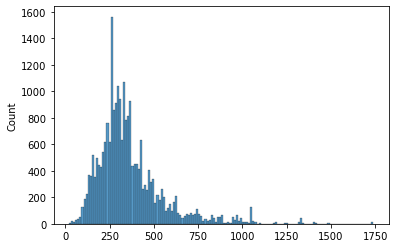

In [10]:
# chain length distribution
sns.histplot([len(case_dict['entity_info']['pdbx_seq_one_letter_code']) for key, case_dict in cases_filt.items()])

<AxesSubplot:ylabel='Count'>

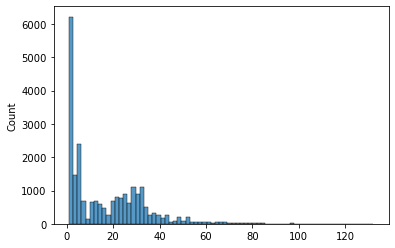

In [11]:
# ligand group size distribution
sns.histplot([
    sum([y['num_heavy_atoms'] for y in {x['name']: x for x in case_dict['ligand_groups']}[key[1]]['ligands']]) for key, case_dict in cases_filt.items()
])

In [12]:
alphabet = set()
for key, case_dict in cases_filt.items():
    alphabet |= set(list(case_dict['entity_info']['pdbx_seq_one_letter_code']))
alphabet

{'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 'Z'}

In [13]:
# we found one case with Z amino acid
for key, case_dict in cases_filt.items():
    if 'Z' in case_dict['entity_info']['pdbx_seq_one_letter_code']:
        print(case_dict)
        break

{'case_name': '6CRN_A', 'pdb_id': '6CRN', 'pdb_chain': 'A', 'instance_id': 'A', 'entity_id': '1', 'experiment': 'X-RAY DIFFRACTION', 'resolution': 2.5, 'deposition_date': '2018-03-19T00:00:00+0000', 'seqclus100': 31355, 'seqclus90': 8230, 'seqclus40': 4645, 'seqclus30': 4498, 'missing_residue': '111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111', 'missing_ca': '1111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [14]:
# filter out ligands that can't be featurized

_cases_filt = OrderedDict()

for k, case_dict in tqdm(list(cases_filt.items())[:]):
    group_dict = {x['name']: x for x in case_dict['ligand_groups']}[k[1]]
    try:
        for lig_dict in group_dict['ligands']:
            mol = Chem.MolFromSmiles(lig_dict['smiles'])
            mol_3d = Chem.MolFromMolFile(Path('data/cases') / case_dict['case_name'] / group_dict['name'] / lig_dict['sdf_id'] + '.mol', removeHs=True)
            lig_feats = features.ligand_featurize(mol, mol_3d)
            np.save(f"data/featurized/{lig_dict['sdf_id']}.ligand_feats.npy", lig_feats)
        _cases_filt[k] = case_dict
    except:
        print(k)
        traceback.print_exc()

  2%|▏         | 553/23697 [00:04<02:47, 138.53it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
  2%|▏         | 583/23697 [00:04<02:53, 133.38it/s]

(Path('1FFT_A'), 'CU_HEO')


  3%|▎         | 625/23697 [00:04<02:57, 130.26it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
  3%|▎         | 651/23697 [00:05<03:33, 108.11it/s]

(Path('1FUO_A'), 'MLT')
(Path('1FUP_A'), 'MLT')


  5%|▍         | 1118/23697 [00:09<02:54, 129.17it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
  5%|▍         | 1134/23697 [00:09<02:47, 134.61it/s]

(Path('1JOL_A'), 'FFO')


  6%|▌         | 1451/23697 [00:11<02:48, 131.97it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
  6%|▌         | 1478/23697 [00:11<03:01, 122.21it/s]

(Path('1MMG_A'), 'AGS_MG')


  6%|▋         | 1491/23697 [00:11<02:58, 124.10it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
  6%|▋         | 1521/23697 [00:12<02:50, 130.10it/s]

(Path('1MU9_A'), 'GOL_VO4')


 12%|█▏        | 2765/23697 [00:21<02:53, 120.96it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 12%|█▏        | 2778/23697 [00:21<03:07, 111.67it/s]

(Path('1XDY_A'), 'MTE_W')


 27%|██▋       | 6425/23697 [00:53<02:58, 96.52it/s] Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 27%|██▋       | 6452/23697 [00:53<02:42, 106.10it/s]

(Path('3B9X_A'), 'CA_NOS')


 30%|██▉       | 7019/23697 [00:58<02:06, 132.02it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 30%|██▉       | 7046/23697 [00:58<02:17, 121.37it/s]

(Path('3ECR_A'), 'DPM')


Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 30%|██▉       | 7075/23697 [00:58<02:29, 111.20it/s]

(Path('3EGW_A'), '6MO_MD1_MGD')


 30%|███       | 7115/23697 [00:58<02:32, 109.04it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 30%|███       | 7127/23697 [00:59<02:35, 106.55it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError


(Path('3EQ1_A'), 'DPM')
(Path('3EQC_A'), '3BM_AGS_MG')
(Path('3EQD_A'), 'AGS_MG')


 31%|███▏      | 7420/23697 [01:01<02:05, 129.81it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 31%|███▏      | 7447/23697 [01:01<02:16, 118.99it/s]

(Path('3FZP_A'), 'AGS')


 32%|███▏      | 7539/23697 [01:02<02:11, 122.96it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 32%|███▏      | 7575/23697 [01:02<01:52, 142.69it/s]

(Path('3GLC_A'), 'R5P')


 57%|█████▋    | 13403/23697 [01:51<01:17, 132.60it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 57%|█████▋    | 13435/23697 [01:52<01:18, 131.50it/s]

(Path('4KN7_C'), '1RM')


 68%|██████▊   | 16088/23697 [02:12<00:56, 133.94it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 68%|██████▊   | 16115/23697 [02:12<01:03, 118.91it/s]

(Path('4YZS_B'), 'W')


 68%|██████▊   | 16154/23697 [02:13<01:08, 110.78it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 68%|██████▊   | 16168/23697 [02:13<01:16, 99.00it/s] Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 68%|██████▊ 

(Path('4ZFX_A'), 'EB4_TH')
(Path('4ZFX_B'), 'TH')
(Path('4ZHC_A'), 'TC2_TH')


 74%|███████▍  | 17612/23697 [02:26<00:57, 105.56it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 74%|███████▍  | 17636/23697 [02:27<00:56, 106.91it/s]

(Path('5FKJ_B'), 'G0W')


 78%|███████▊  | 18571/23697 [02:35<01:32, 55.57it/s] Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 78%|███████▊  | 18586/23697 [02:35<01:17, 65.92it/s]

(Path('5KCF_A'), 'OB5')


 79%|███████▊  | 18608/23697 [02:36<01:12, 70.55it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 79%|███████▊  | 18622/23697 [02:36<01:01, 81.87it/s]

(Path('5KHP_A'), '7K9_ZR')
(Path('5KID_A'), '7K9_TH')


 87%|████████▋ | 20532/23697 [02:50<00:28, 110.71it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
 87%|████████▋ | 20564/23697 [02:50<00:25, 123.55it/s]

(Path('5URG_B'), 'NAP')


100%|█████████▉| 23613/23697 [03:15<00:00, 139.85it/s]Traceback (most recent call last):
  File "<ipython-input-14-6528b01ed359>", line 11, in <module>
    lig_feats = features.ligand_featurize(mol, mol_3d)
  File "/home/ignatovmg/projects/alphadock/alphadock/features.py", line 506, in ligand_featurize
    assert len(matches) > 0
AssertionError
100%|█████████▉| 23642/23697 [03:16<00:00, 134.14it/s]

(Path('6QDX_D'), 'HY8')


100%|██████████| 23697/23697 [03:16<00:00, 120.53it/s]


In [15]:
cases_filt = _cases_filt

In [16]:
utils.write_json(list(cases_filt.keys()), 'data/cases_filt_keys.json')

In [17]:
cases_filt = OrderedDict([((k[0], k[1]), cases_unfilt[k[0]]) for k in utils.read_json('data/cases_filt_keys.json')])

In [18]:
element_counts = []
for key in cases_filt.keys():
    group_dict = {x['name']: x for x in cases_filt[key]['ligand_groups']}[key[1]]
    for lig_dict in group_dict['ligands']:
        element_counts += sorted(set([x.GetSymbol().upper() for x in Chem.MolFromSmiles(lig_dict['smiles']).GetAtoms()]))
element_counts = Counter(element_counts)

In [19]:
sorted(element_counts.items(), key=lambda x: -x[1])

[('O', 18063),
 ('C', 17385),
 ('N', 11872),
 ('S', 4438),
 ('P', 4417),
 ('ZN', 2764),
 ('CL', 2400),
 ('MG', 1789),
 ('F', 1726),
 ('NA', 836),
 ('CA', 684),
 ('FE', 557),
 ('MN', 437),
 ('K', 303),
 ('BR', 257),
 ('NI', 135),
 ('I', 117),
 ('CU', 77),
 ('AL', 75),
 ('CO', 55),
 ('V', 24),
 ('B', 17),
 ('AS', 14),
 ('BE', 13),
 ('MO', 10),
 ('W', 10),
 ('HG', 9),
 ('SR', 8),
 ('SE', 8),
 ('XE', 6),
 ('CD', 5),
 ('SI', 5),
 ('AU', 5),
 ('GD', 5),
 ('CS', 5),
 ('RU', 5),
 ('BA', 5),
 ('AG', 4),
 ('PB', 3),
 ('SM', 3),
 ('LI', 3),
 ('SN', 3),
 ('YB', 2),
 ('Y', 2),
 ('PT', 2),
 ('EU', 2),
 ('PR', 2),
 ('RE', 2),
 ('LA', 2),
 ('OS', 1),
 ('ER', 1),
 ('RH', 1),
 ('CR', 1),
 ('PU', 1),
 ('AM', 1),
 ('CF', 1),
 ('AR', 1)]

In [20]:
chemid_to_pdb_list = defaultdict(list)
for k, case in cases_filt.items():
    for group in case['ligand_groups']:
        for ligand in group['ligands']:
            chemid_to_pdb_list[ligand['chemid']].append(case['pdb_id'])
chemid_to_pdb_list = {k: sorted(set(v)) for k, v in chemid_to_pdb_list.items()}

In [21]:
chemid_to_pdb_list['EAA']

['11GS', '1GSF', '2GSS', '3HJO', '3KM6', '3KMO', '3N9J']

In [22]:
def get_frag_templates(case_name, group_dict, cases):
    frag_templates = []
    tar_mols = [Chem.MolFromSmiles(x['smiles']) for x in group_dict['ligands']]
    assert all([x.GetNumHeavyAtoms() == x.GetNumAtoms() for x in tar_mols])
    tar_size = sum([x.GetNumHeavyAtoms() for x in tar_mols])
    tar_id_shift = 0
    
    for tar_lig_id, tar_lig in enumerate(group_dict['ligands']):
        tpl_ligs = chemid_to_matches[tar_lig['chemid']]
        
        for tpl_chemid, match_dict in tpl_ligs.items():
            tpl_pdbs = chemid_to_pdb_list.get(tpl_chemid, [])
            
            for tpl_pdb in tpl_pdbs:
                tpl_case_keys = [x for x in cases.keys() if x[0][:4] == tpl_pdb and tpl_chemid in x[1]]
                
                for tpl_case_name, tpl_group_name in tpl_case_keys:
                    if tpl_case_name == case_name:
                        continue
                    tpl_case_dict = cases[(tpl_case_name, tpl_group_name)]
                    tpl_group = {x['name']: x for x in tpl_case_dict['ligand_groups']}[tpl_group_name]
                    tpl_group_id = {x['name']: i for i, x in enumerate(tpl_case_dict['ligand_groups'])}[tpl_group_name]
                    
                    for tpl_lig_id, tpl_lig_dict in enumerate(tpl_group['ligands']):
                        if tpl_chemid == tpl_lig_dict['chemid']:
                            break
                    assert tpl_chemid == tpl_lig_dict['chemid']
                    
                    # find matches
                    tar_mol = tar_mols[tar_lig_id]
                    tpl_mol = Chem.MolFromSmiles(tpl_lig_dict['smiles'])
                    smarts_mol = Chem.MolFromSmarts(match_dict['mcs_smarts'])
                    tar_matches = tar_mol.GetSubstructMatches(smarts_mol, uniquify=False)
                    tpl_matches = tpl_mol.GetSubstructMatches(smarts_mol, uniquify=False)

                    # EAA and EIM produce a match, but smarts doesnt match EIM - report a bug I guess
                    # so sometimes even if there is a smarts it can still result in no matches
                    #assert len(tar_matches) > 0
                    #assert len(tpl_matches) > 0
                    if len(tar_matches) * len(tpl_matches) == 0:
                        continue

                    tpl_id_shift = 0
                    for tpl_lig in tpl_group['ligands'][:tpl_lig_id]:
                        tpl_mol = Chem.MolFromSmiles(tpl_lig['smiles'])
                        assert tpl_mol.GetNumHeavyAtoms() == tpl_mol.GetNumAtoms()
                        tpl_id_shift += tpl_mol.GetNumHeavyAtoms()

                    matches = []
                    for tar_m in tar_matches:
                        tar_m = np.array(tar_m, dtype=np.int32) + tar_id_shift
                        for tpl_m in tpl_matches:
                            tpl_m = np.array(tpl_m, dtype=np.int32) + tpl_id_shift
                            match = np.full(tar_size, -1)
                            match[tar_m] = tpl_m
                            matches.append(match.tolist())

                    frag_templates.append({
                        'tar_chemid': tar_lig['chemid'],
                        'tar_smiles': tar_lig['smiles'],
                        'tar_lig_id': tar_lig_id,
                        'tpl_chain': tpl_case_name,
                        'tpl_seqclus30': tpl_case_dict['seqclus30'],
                        'tpl_group': tpl_group_name,
                        'tpl_group_id': tpl_group_id,
                        'tpl_chemid': tpl_chemid,
                        'tpl_lig_id': tpl_lig_id,
                        'match': match_dict,
                        'tar_matches': tar_matches,
                        'tpl_matches': tpl_matches,
                        'mapping_to_target': matches
                    })
                    
        assert tar_mols[tar_lig_id].GetNumHeavyAtoms() == tar_mols[tar_lig_id].GetNumAtoms()
        tar_id_shift += tar_mols[tar_lig_id].GetNumHeavyAtoms()
        
    return frag_templates

_run_mp(cases_unfilt['1AND_A'])

NameError: name '_run_mp' is not defined

In [ ]:
'''for k, case_dict in tqdm(list(cases_filt.items())[:10]):
    print(k)
    for group_dict in case_dict['ligand_groups']:
        frag_templates = get_frag_templates(case_dict['case_name'], group_dict, cases_filt)
        if len(frag_templates) > 0:
            with open(f"data/featurized/{case_dict['case_name']}.{group_dict['name']}.fragment_matches.json", 'w') as f:
                json.dump(frag_templates, f)'''

In [45]:
'''for k, case_dict in tqdm([x for x in cases_filt.items() if x[0][0] == '4RX7_A' and x[0][1] == '3YV_GOL']):
    print(k)
    for group_dict in case_dict['ligand_groups']:
        frag_templates = get_frag_templates(case_dict['case_name'], group_dict, cases_filt)
        if len(frag_templates) > 0:
            with open(f"data/featurized/{case_dict['case_name']}.{group_dict['name']}.fragment_matches.json", 'w') as f:
                json.dump(frag_templates, f)
                
        #frag_feats = features.fragment_template_featurize(case_dict, group_dict)
        #np.save(f"data/featurized/{case_dict['case_name']}.{group_dict['name']}.fragment_feats.npy", frag_feats)'''

  0%|          | 0/1 [00:00<?, ?it/s]

(Path('4RX7_A'), '3YV_GOL')


100%|██████████| 1/1 [00:58<00:00, 58.77s/it]


In [43]:
def _run_mp(key):
    case_dict = cases_filt[key]
    group_dict = {x['name']: x for x in case_dict['ligand_groups']}[key[1]]
    try:
        frag_templates = get_frag_templates(case_dict['case_name'], group_dict, cases_filt)
        if len(frag_templates) > 0:
            with open(f"data/featurized/{case_dict['case_name']}.{group_dict['name']}.fragment_matches.json", 'w') as f:
                json.dump(frag_templates, f)
    except:
        return key, traceback.format_exc()
                
with Pool(32) as pool:
    for case_name in pool.imap_unordered(_run_mp, tqdm(list(cases_filt.keys()))):
        if case_name is not None:
            print(case_name)

100%|██████████| 23671/23671 [2:15:18<00:00,  2.92it/s]  


In [162]:
mol = Chem.MolFromSmiles('[Zn+2]')
mol.GetSubstructMatches(mol)

((0,),)

In [105]:
chemid_to_matches['VWW']

{'VWW': {'ref_chemid': 'VWW',
  'ref_smiles': 'c1ccc(cc1)CSC[C@@H](C(=O)N[C@H](c2ccccc2)C(=O)O)NC(=O)CC[C@@H](C(=O)O)N',
  'mcs_flags': ['r'],
  'fp_tanimoto': 1.0,
  'mcs_tar_coverage': 1.0,
  'mcs_ref_coverage': 1.0,
  'mcs_tanimoto': 1.0,
  'mcs_smarts': '[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@[#6&R]:&@1)-&!@[#6&!R]-&!@[#16&!R]-&!@[#6&!R]-&!@[#6&!R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6&!R](-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])-&!@[#7&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])-&!@[#7&!R]',
  'mcs_num_atoms': 33,
  'mcs_num_bonds': 34},
 'XLI': {'ref_chemid': 'XLI',
  'ref_smiles': 'CCCCNC(=O)[C@H](C)C[C@@H]([C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)C)O',
  'mcs_flags': ['r'],
  'fp_tanimoto': 0.4812332439678284,
  'mcs_tar_coverage': 0.45454545454545453,
  'mcs_ref_coverage': 0.40540540540540543,
  'mcs_tanimoto': 0.2727272727272727,
  'mcs_sma

In [41]:
Path('data/train_split').mkdir_p()

debug_case = {
    'case_name': case_dict['case_name'],
    'group_name': group_dict['name'],
    'fragment_templates': frag_templates,
    'hhpred_templates': []
}

utils.write_json([debug_case], 'data/train_split/debug.json')

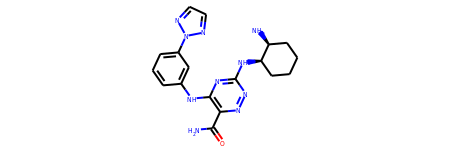

In [23]:
Chem.MolFromSmiles('c1cc(cc(c1)n2nccn2)Nc3c(nnc(n3)N[C@@H]4CCCC[C@@H]4N)C(=O)N')

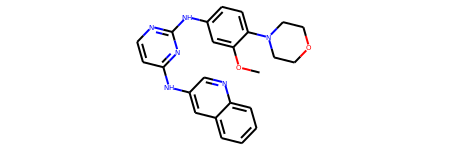

In [24]:
Chem.MolFromSmiles('COc1cc(ccc1N2CCOCC2)Nc3nccc(n3)Nc4cc5ccccc5nc4')